In [1]:
%cd /home/lzheng/git/Markowitz_Optim/

/home/lzheng/git/Markowitz_Optim


In [22]:
# auto reload imported modules when they are modified
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import scipy
import random

# display settings of pandas tables
pd.set_option('display.max_rows', 50)
pd.set_option('display.min_rows', 50)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.precision', 4)
# pd.set_option('display.float_format', '{:,}'.format)
# pd.reset_option('display.float_format')
# pd.reset_option('display.max_rows')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# load data
folder = 'CHINA_ALL'
root = 'data'

df_uni = pd.read_parquet(os.path.join(root, folder, 'csi300.parquet'))
df_ret = pd.read_parquet(os.path.join(root, folder, 'ret.parquet'))

In [28]:
df_ret.head(5)

,000001.SZ,000021.SZ,000027.SZ,000089.SZ,000550.SZ,000612.SZ,000625.SZ,000630.SZ,000652.SZ,000768.SZ,...,688187.SS,300769.SZ,002180.SZ,600039.SS,601615.SS,000733.SZ,600884.SS,600732.SS,000617.SZ,688223.SS
2009-01-06,0.0608,0.0346,0.0458,0.0762,0.0358,0.0508,NaN,0.0410,NaN,0.0663,...,NaN,NaN,0.0293,0.0270,NaN,0.0322,0.0324,0.0126,0.0418,NaN
2009-01-07,-0.0301,0.0022,-0.0138,-0.0397,NaN,0.0121,NaN,0.0299,NaN,0.0179,...,NaN,NaN,-0.0347,-0.0181,NaN,0.0089,0.0111,-0.0036,-0.0027,NaN
2009-01-08,-0.0390,-0.0245,0.0035,-0.0108,-0.0601,-0.0263,NaN,-0.0475,NaN,0.0274,...,NaN,NaN,-0.0414,-0.0452,NaN,-0.0331,-0.0456,0.0161,-0.0430,NaN
2009-01-09,0.0260,0.0228,0.0093,-0.0164,0.0154,0.0306,NaN,0.0402,NaN,0.0041,...,NaN,NaN,0.0548,0.0333,NaN,0.0594,0.0994,0.0229,0.0196,NaN
2009-01-12,0.0010,0.0156,-0.0012,-0.0148,0.0385,0.0333,NaN,0.0240,NaN,0.0020,...,NaN,NaN,0.0018,0.0102,NaN,0.0086,0.0504,-0.0017,0.0124,NaN


In [29]:
df_uni.head(5)

ID_QI,000001.SZ,000021.SZ,000027.SZ,000089.SZ,000550.SZ,000612.SZ,000625.SZ,000630.SZ,000652.SZ,000768.SZ,...,688187.SS,300769.SZ,002180.SZ,600039.SS,601615.SS,000733.SZ,600884.SS,600732.SS,000617.SZ,688223.SS
TS,,,,,,,,,,,,,,,,,,,,,
2008-03-03,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2008-03-04,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2008-03-05,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2008-03-06,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2008-03-07,True,True,True,True,False,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False


# Theorem - Markowitz Optimization

## Efficient Frontier

Before going into the Markowitz Optimization, we need to first talk about the efficient frontier, which is the pattern we can found when doing Monte Carlo simulation on weights of stocks in the portfolio.

When we set up a portfolio of many instuments, not only its expected return is what we care about, also the risk of holding this portfolio impacts the performance a lot. Each investment instrument has its own expected return and risk (usually estimated by the historical return average and volatility). When they are put into a portfolio, their total return and risk are greatly affected by the weights combining them, i.e. the weighting method. So one can generate many portfolios of the same stocks with different expected return and risk by different weighting methods. And obvious that we can always optimize the portfolio to have minimum risk or maximum return. 

The efficient frontier is that when we generate many portfolios and mark them as scatter points on a plot of return against risk, we will find a sharp edge on the left side of the points (as shown below). That is called the efficient frontier where we can find the least risky portfolios at given expected returns. And the maximum expected return portfolios are located on the upper part of the frontier. 

Below is the Monte Carlo simulation of these portfolios. I use the lasted 1-year returns of stocks to estimate the expected returns and risks. And only a portfolio of 10 stocks is consider, as it would require much more samples to profile the frontier if more stocks in the portfolio. 

## Markowitz Optimization

Now we know that the portfolios on the efficient frontier are the most efficient. The Markowitz optimization is there to optimize the portfolio to the most efficient one. It solves the problem below. 

$$
argmax_w   (\mu^T  w - \gamma  \sqrt{ w^T C w}) \\
$$

subject to

$$
\begin{aligned}
1^T w &= 1\\
\sum{|w- w_0|} &< 0.15\\
max(0, w_{ew} - 0.03) < w &< min(1, w_{ew} + 0.03) \\
\end{aligned}
$$

The practical constrains are given by the problem:
1. Normalized portfolio: $\sum{w} = 1$
2. Maximum turnover: 0.15
3. Maximum deviation from equal weighted index: 0.03
4. Long only as an index: w in \[0, 1)

$\mu$ and $C$ are the expected return and the covariance matrix respectively, while $w_{ew}$ is the weights of equal weighted index, and $w_0$ is weights of last trade day. \gamma is a coeeficient reflecting the return-risk preference. Greater than 1 implys more risk aversion, while less than 1 aggressive.  

Graphically, it is to move the line $return = \gamma \times risk + a$ all the way up until it tangent to the efficient frontier, i.e. maximize $a$. This is a convex problem.

__Extension__: 

Another optimization method to maximize the Sharpe ratio also trys to find an optimal point on the efficient frontier. But the difference is that, it is trying to find a line passing through the origin that having the max slope, i.e. maximize $\gamma$ of line $return = \gamma \times risk$. This one is neither convex or concave.


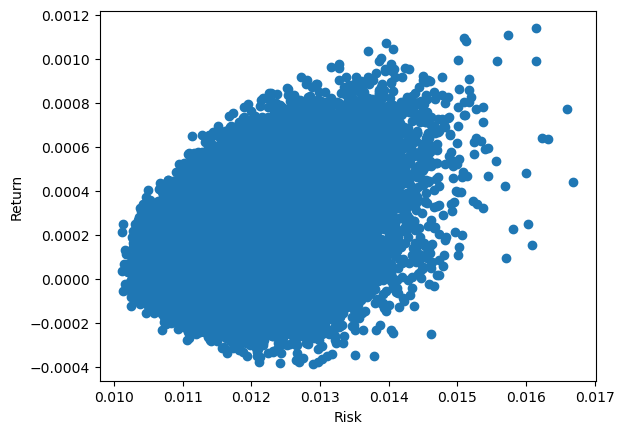

In [32]:

ret_matrix = df_ret.iloc[-255:, :10].fillna(0).values
ls = []
for i in range(50000):
    weight = np.random.rand(ret_matrix.shape[1])
    weight /= weight.sum()
    
    MeanReturns = np.mean(ret_matrix, axis=0)
    CovarReturns = np.cov(ret_matrix.T)
    risk = np.sqrt(np.matmul(np.matmul(weight, CovarReturns), weight.T) )
    ret = np.matmul(np.array(MeanReturns), weight.T)
    ls.append([risk, ret])

plt.scatter(*list(zip(*ls)))
plt.xlabel('Risk')
plt.ylabel('Return')
plt.show()

# Predefined Functions

The functions here are not specifically designed for the problem. They are used in my daily research. So they contain extra codes to make sure their are robust to handle non-perfectly formated inputs, and has extensive features, like you can specify update frequency and window size when needed, backtest a complex compound strategy, etc. 



### Factor Handling Functions

In [4]:
def transform_rolling3D(df, freq, win):
    # reshape the data format to add one more window dimention without use extra memory
    # This will save more time by applying vector operation than using rolling function
    # adding a extra axis having the same length as rolling win_size, and resample the lookback freq on the first dimension 
    # input shape (time, features), output (time in freq, features, win_size)
    ar = df.sort_index().values
    shape = (int(np.ceil((ar.shape[0] - win + 1) / freq)), ar.shape[1], win)
    strides = (ar.strides[0] * freq, ar.strides[1], ar.strides[0])
    return np.lib.stride_tricks.as_strided(ar, shape=shape, strides=strides)
    
def resample_2tradedays(df, trade_idx):
    # resample df having freq lower than trade_idx to align with trade_idx trading freq, ffill the value in between
    # nan will be filled by 0
    return df.fillna(0).sort_index().asfreq('D', method='ffill').reindex(trade_idx).ffill().mask(lambda x: x==0)

def cal_MeanVariance_intercept(x, MeanReturns, CovarReturns, gamma=1, RiskFreeRate=0):
    # the objective function to optimize
    # gamma set to 1, equal return and risk preference
    risk = np.sqrt(np.matmul(np.matmul(x, CovarReturns), x.T) )
    ret = np.matmul(np.array(MeanReturns),x.T)-RiskFreeRate
    func = gamma * risk - ret
    return func

### PNL Calculation Functions

In [11]:
def cal_pnl(dpnl: pd.Series, compound=False):
    return ((dpnl+1).cumprod() - 1).rename('PNL') if compound else dpnl.cumsum().rename('PNL')


def calc_perf(pos_in: pd.DataFrame, ret: pd.DataFrame=df_ret, fees=5, compound=False):
    pos = pos_in.sort_index().replace(0, np.nan).dropna(axis=0, how='all').copy()
    ret_in = ret[pos.index[0]: pos.index[-1]]
    pos = pos.reindex(ret_in.index, fill_value=0)  # make sure the pnl has full length, to distiguish pnl and eff pnl
    ddpnl = ret_in.multiply(pos_in.shift(1), fill_value=0)
    pnl = ddpnl.sum(axis=1)

    pos = pos.fillna(0).sort_index()
    booksize = pos.abs().sum(axis=1).fillna(0)
    turnover = (pos - pos.shift(1).fillna(0)).abs().sum(axis=1).fillna(0)
    net_pnl = pnl.sub(turnover * fees * 1e-4, fill_value=0)
    pnl_l = cal_pnl(pnl, compound) + 1
    
    summary = pd.Series(dtype=float)
    summary['Return'] = pnl.mean() * 255
    summary['Std'] = pnl.std() * np.sqrt(255)
    summary['maxDD (%)'] = (pnl_l - pnl_l.cummax()).min() * 100
    summary["Win Rate (%)"] = (pnl > 0).mean() * 100
    summary["Sharpe"] = summary['Return'] / summary['Std']
    summary["Net Sharpe"] = net_pnl.mean() * np.sqrt(255) / net_pnl.std()
    summary["Turnover (%)"] = 100 * turnover.sum() / booksize.sum()
    summary["Bias (bp)"] = 10000 * pnl.sum() / turnover.sum()
    return pnl, net_pnl, summary

### Result Visuallization Functions

In [12]:
def set_styler_pn_distinguish(df: pd.DataFrame, title='Table', max_axis=1, thres_opti=0.02, precision=4) -> pd.DataFrame.style:
    def style_negative(v, props=''):
        return props if v < 0 else None
    def highlight_max(s, props=''):
        return np.where(s == np.nanmax(s.values), props, '')
    def highlight_min(s, props=''):
        return np.where(s == np.nanmin(s.values), props, '')

    s = df.style
    s = s.applymap(style_negative, props='color:red;')							# change text color of negative values
    s = s.apply(highlight_max, props='color:white;background-color:darkblue', axis=max_axis)    # highlight max value with background
    s = s.apply(highlight_min, props='color:white;background-color:darkred', axis=max_axis)    # highlight max value with backgroundhighlight max value with background
    s = s.set_caption(title).set_table_styles([{        # set caption of the table
                        'selector': 'caption', 'props': 'caption-side: bottom; font-size:1.25em;'
                    }], overwrite=False)
    s = s.set_table_styles([
            {'selector': 'th.col_heading', 'props': 'text-align: center;'},        # headers
            {'selector': 'th.row_heading', 'props': 'font-weight: bold;'},        # headers
        ], overwrite=False)
    s = s.format(precision=precision)
    return s

def show_results(dpnl=None, dpnlc=None, m=None, show_keys=None, legend_loc='best', show_ncols=5, figsize=(10, 6), mtc_transpose=True, precision=4, title='Strategy', attach_title=True):
    if dpnl is not None:
        if show_keys is None:
            keys = dpnl.columns
        else: 
            keys = show_keys
        str_title = ' - Without cost' if attach_title else ''
        p = dpnl.set_axis(keys, axis=1).apply(cal_pnl, axis=0, compound=False)
        ax = p.plot(figsize=figsize, grid=True, alpha=0.9)# Shrink current axis's height by 10% on the bottom
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1,
                         box.width, box.height * 0.9])
        # Put a legend below current axis
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                  fancybox=True, shadow=False, ncol=show_ncols)
        ax.axhline(0, alpha=0.5, color='grey')
        ax.set_title(title + str_title)
        plt.show()
    
    if dpnlc is not None:
        if show_keys is None:
            keys = dpnlc.columns
        else: 
            keys = show_keys
        str_title = ' - With cost' if attach_title else ''
        p = dpnlc.set_axis(keys, axis=1).apply(cal_pnl, axis=0, compound=False)
        ax = p.plot(figsize=figsize, grid=True, alpha=0.9)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1,
                         box.width, box.height * 0.9])
        # Put a legend below current axis
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                  fancybox=True, shadow=False, ncol=show_ncols)
        ax.axhline(0, alpha=0.5, color='grey')
        ax.set_title(title + str_title)
        plt.show()
        
    if m is not None:
        if show_keys is None:
            keys = m.columns
        else: 
            keys = show_keys
        if mtc_transpose:
            display(set_styler_pn_distinguish(m.set_axis(keys, axis=1).T, title=title, max_axis=0, precision=precision))
        else:
            display(set_styler_pn_distinguish(m.set_axis(keys, axis=1), title=title, max_axis=1, precision=precision))

# Data Preparing

Prepare the data and its format in this section.

One thing to notice is that, I used the ret255 momentum as a prediction of expected return here. Originally, the expected return should be calculated by $\beta \times ret255$, where $\beta$ obtained from regression. But multiplying this $\beta$ won't affect anything solving the problem. So the ret255 is directed regarded as expected return.

Besides, I also use the daily returns in the 255 days look-back window to calculated the covariance matrix, which is then used as the estimated risks. Because there are usually correlations among stocks, the total risk is not simple the weighted sum of individuals. The covariance takes into accounts the shared volatility. 


In [5]:
deviation = 0.03
max_weight_change = 0.15
win = 255
freq = 1

df_weight_index = df_uni[df_uni].div(df_uni.sum(1), axis=0).astype(float)  # equal weighted index  
df_ret, df_weight_index = df_ret.dropna(how='all').align(df_weight_index, join='left', fill_value=0)

# reshape the data we need into 3D rolling structures of shape (time step, instruments, rolling window) without taking extra memory 
ar_index = transform_rolling3D(df_weight_index, freq=freq, win=win)
ar_3Dreturns = transform_rolling3D(df_ret.fillna(0), freq=freq, win=win)

ar_3Dcov = np.array(list(map(lambda m: np.cov(m), np.nan_to_num(ar_3Dreturns)))) # Covariances on everyday 
ar_2Dfactor = np.nanmean(ar_3Dreturns, axis=2, keepdims=False)                   # Expected Returns on everyday 


# Position Generating

In [6]:
# EST is 2h
# can skip this code cell and load the weight from disk by running the next next cell

ls_weight = []
# last_weight = ar_index[0].T[0]
for i in tqdm(range(len(ar_2Dfactor)), ncols=120, desc='Iterate days: '):
    index_wt = ar_index[i, :, -1]
    MeanReturns = ar_2Dfactor[i]
    CovarReturns = ar_3Dcov[i]
    mask = np.isnan(index_wt.tolist())

    if i == 0:
        last_weight = index_wt

    #define equality constraint representing fully invested portfolio
    def constraintSum1(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b 
        return constraintVal
    def constraintChange(x, last_weight=last_weight, max_change=max_weight_change):
        constraintVal = max_change - np.sum(abs(x - last_weight))
        return constraintVal

    #define bounds and other parameters
    xinit = np.nan_to_num(index_wt)
    cons = ({'type': 'eq', 'fun':constraintSum1}, 
            {'type': 'ineq', 'fun':constraintChange})
    
    lower = np.nan_to_num((index_wt - deviation).clip(min=0))
    upper = np.nan_to_num((index_wt + deviation).clip(max=1))
    lower[mask] = 0
    upper[mask] = 0
    bnds = tuple(zip(lower, upper))
    #invoke minimize solver
    opt = scipy.optimize.minimize (cal_MeanVariance_intercept, 
                                   x0=xinit, 
                                   args=(MeanReturns, CovarReturns, 0), 
                                   method='SLSQP', 
                                   bounds=bnds, 
                                   constraints=cons, 
                                   tol=1e-5)
    weight = opt.x
    ls_weight.append(weight)
    last_weight = weight
    

In [18]:
df_w = pd.DataFrame(ls_weight, index=df_ret.index[win-1::freq], columns=df_ret.columns)
df_w = df_w.mask(lambda x: x<1e-8).fillna(0)
df_w = resample_2tradedays(df_w, df_ret.index).dropna(how='all').dropna(axis=1, how='all')
df_w.to_parquet('weights.parquet')


In [ ]:
df_w = pd.read_parquet('weights.parquet')

# Backtest

The transaction cost is set to lump-sum value of 5 bps in China market. 

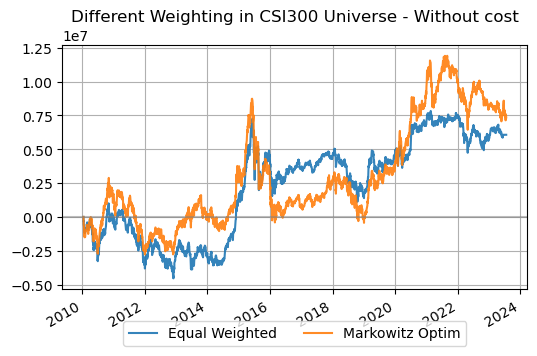

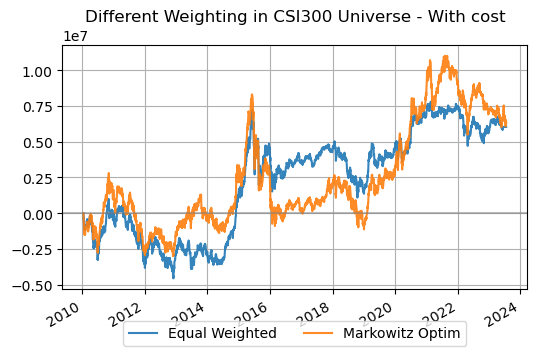

,Return,Std,maxDD (%),Win Rate (%),Sharpe,Net Sharpe,Turnover (%),Bias (bp)
Equal Weighted,0.0472,0.2347,-61.3976,51.5096,0.2011,0.2000,0.2173,857.9115
Markowitz Optim,0.0572,0.2878,-91.7340,51.9366,0.1987,0.1699,6.4841,34.5829


In [17]:
# backtest
capital = 1e7 # initial capital

df_weights = pd.concat([df_w, df_weight_index], axis=1, keys=['Markowitz Optim', 'Equal Weighted']).replace(0, np.nan).stack()
df_weights = df_weights[df_weights.dropna().index[0]:]

# df_pos = df_weights * capital
results = [calc_perf(sr.unstack()) for col, sr in df_weights.items()]
p, pc, m = [pd.concat(itm, axis=1, keys=df_weights.columns) for itm in zip(*results)]
show_results(p*capital, pc*capital, m, figsize=(6, 4), title='Different Weighting in CSI300 Universe')
